# SMA_移动平均及双均线模型

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
# plt.style.use('seaborn')             ggplot;
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'               #解决一些字体显示乱码问题
import warnings; warnings.simplefilter('ignore')       #忽略警告信息；

In [2]:
import numpy as np
import pandas as pd
import tushare as ts

### 前导知识学习

In [14]:
# Tushare API
data = ts.get_k_data('600030', start = '2010-01-01', end='2017-06-30') 

In [15]:
data.head()    #DataFrame数据结构

,date,open,close,high,low,volume,code
0,2010-01-04,17.809,17.413,17.975,17.386,1106207.58,600030
1,2010-01-05,17.558,18.265,18.421,17.146,2093915.41,600030
2,2010-01-06,18.365,18.053,18.449,18.031,1437889.30,600030
3,2010-01-07,18.042,17.614,18.298,17.475,1235592.34,600030
4,2010-01-08,17.497,17.953,18.009,17.419,1040929.92,600030


In [16]:
data.set_index('date', inplace = True)   #设置索引；替换，真实覆盖；

In [17]:
data.head()

,open,close,high,low,volume,code
date,,,,,,
2010-01-04,17.809,17.413,17.975,17.386,1106207.58,600030
2010-01-05,17.558,18.265,18.421,17.146,2093915.41,600030
2010-01-06,18.365,18.053,18.449,18.031,1437889.30,600030
2010-01-07,18.042,17.614,18.298,17.475,1235592.34,600030
2010-01-08,17.497,17.953,18.009,17.419,1040929.92,600030


In [18]:
data['SMA_20'] = data['close'].rolling(20).mean()

In [19]:
data['SMA_60'] = data['close'].rolling(60).mean() 

In [21]:
data.tail()

,open,close,high,low,volume,code,SMA_20,SMA_60
date,,,,,,,,
2017-06-26,16.94,17.26,17.41,16.90,2113195.0,600030,16.5325,16.188000
2017-06-27,17.25,17.11,17.28,17.06,924024.0,600030,16.5685,16.203333
2017-06-28,17.08,17.09,17.27,17.01,871050.0,600030,16.6010,16.219167
2017-06-29,17.08,17.09,17.19,16.98,668341.0,600030,16.6370,16.236167
2017-06-30,17.02,17.02,17.11,16.82,751091.0,600030,16.6690,16.251333


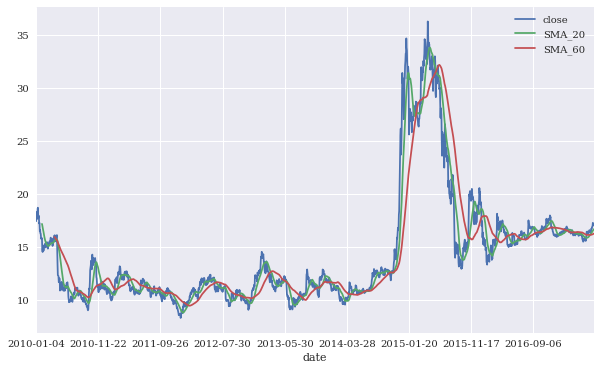

In [23]:
data[['close','SMA_20','SMA_60']].plot(figsize = (10,6))    #可视化

In [27]:
#计算股票return
data['returns'] = np.log(data['close'] / data['close'].shift(1))     
#Numpy向量化操作，避免循环；

In [25]:
data['returns_dis'] = data['close']/data['close'].shift(1)-1

In [29]:
data['return_dis2'] = data['close'].pct_change()

In [30]:
data.head()

,open,close,high,low,volume,code,SMA_20,SMA_60,yes_close,returns_dis,returns,return_dis2
date,,,,,,,,,,,,
2010-01-04,17.809,17.413,17.975,17.386,1106207.58,600030,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,17.558,18.265,18.421,17.146,2093915.41,600030,NaN,NaN,17.413,0.048929,0.047770,0.048929
2010-01-06,18.365,18.053,18.449,18.031,1437889.30,600030,NaN,NaN,18.265,-0.011607,-0.011675,-0.011607
2010-01-07,18.042,17.614,18.298,17.475,1235592.34,600030,NaN,NaN,18.053,-0.024317,-0.024618,-0.024317
2010-01-08,17.497,17.953,18.009,17.419,1040929.92,600030,NaN,NaN,17.614,0.019246,0.019063,0.019246


In [32]:
data['position'] = np.where(data['SMA_20'] > data['SMA_60'], 1, -1)     

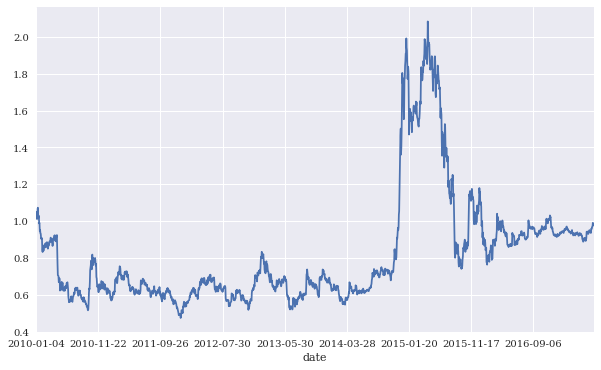

In [33]:
data['returns'].cumsum().apply(np.exp).plot(figsize=(10, 6))  
#可视化；计算累计收益，连续下的算法；

## SMA策略

### 1. 数据准备 & 回测准备

In [34]:
import numpy as np
import pandas as pd
import tushare as ts

In [35]:
data = ts.get_k_data('hs300', start = '2010-01-01', end='2017-06-30')    
#要用Tushare新的数据获取接口，不然数据获取有bug；

In [36]:
data = pd.DataFrame(data)             #把data转换成为DataFrame格式；

In [37]:
data.head()

,date,open,close,high,low,volume,code
0,2010-01-04,3592.468,3536.221,3597.75,3535.38,66101080.0,hs300
1,2010-01-05,3545.186,3564.038,3577.53,3497.66,85809641.0,hs300
2,2010-01-06,3558.700,3542.209,3588.83,3541.17,78473125.0,hs300
3,2010-01-07,3543.160,3472.313,3558.56,3452.77,80350037.0,hs300
4,2010-01-08,3456.908,3480.403,3482.08,3426.70,60613533.0,hs300


In [38]:
data.rename(columns={'close': 'price'}, inplace=True)      #dict

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1819 entries, 0 to 1818
Data columns (total 7 columns):
date      1819 non-null object
open      1819 non-null float64
price     1819 non-null float64
high      1819 non-null float64
low       1819 non-null float64
volume    1819 non-null float64
code      1819 non-null object
dtypes: float64(5), object(2)
memory usage: 113.7+ KB


In [40]:
data.head()

,date,open,price,high,low,volume,code
0,2010-01-04,3592.468,3536.221,3597.75,3535.38,66101080.0,hs300
1,2010-01-05,3545.186,3564.038,3577.53,3497.66,85809641.0,hs300
2,2010-01-06,3558.700,3542.209,3588.83,3541.17,78473125.0,hs300
3,2010-01-07,3543.160,3472.313,3558.56,3452.77,80350037.0,hs300
4,2010-01-08,3456.908,3480.403,3482.08,3426.70,60613533.0,hs300


In [41]:
data.set_index('date', inplace = True)        #覆盖操作；

In [ ]:
data.set_index('date')                        #视图；

In [42]:
data.head()

,open,price,high,low,volume,code
date,,,,,,
2010-01-04,3592.468,3536.221,3597.75,3535.38,66101080.0,hs300
2010-01-05,3545.186,3564.038,3577.53,3497.66,85809641.0,hs300
2010-01-06,3558.700,3542.209,3588.83,3541.17,78473125.0,hs300
2010-01-07,3543.160,3472.313,3558.56,3452.77,80350037.0,hs300
2010-01-08,3456.908,3480.403,3482.08,3426.70,60613533.0,hs300


In [43]:
data['SMA_10'] = data['price'].rolling(10).mean()      #必背

In [44]:
data['SMA_60'] = data['price'].rolling(60).mean()

In [45]:
data.tail()

,open,price,high,low,volume,code,SMA_10,SMA_60
date,,,,,,,,
2017-06-26,3627.02,3668.09,3671.94,3627.02,134637995.0,hs300,3573.455,3475.314500
2017-06-27,3665.58,3674.72,3676.53,3648.76,97558702.0,hs300,3582.700,3478.729667
2017-06-28,3664.16,3646.17,3672.19,3644.03,97920858.0,hs300,3593.787,3481.746000
2017-06-29,3649.25,3668.83,3669.13,3644.73,85589498.0,hs300,3607.791,3485.613833
2017-06-30,3654.73,3666.80,3669.76,3646.23,81510028.0,hs300,3622.595,3489.126333


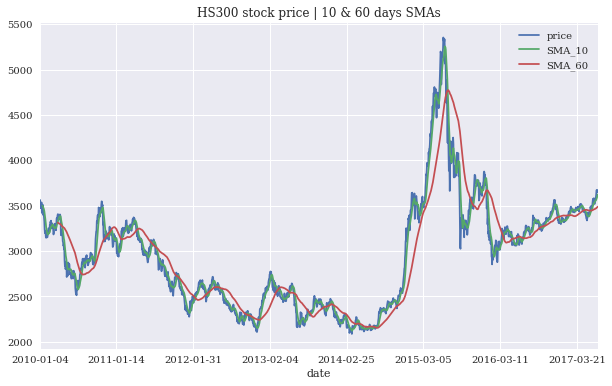

In [48]:
data[['price','SMA_10','SMA_60']].plot(title='HS300 stock price | 10 & 60 days SMAs',
                                       figsize=(10, 6))
#Pandas里面如何选择多列必须要掌握；

### 2. 策略开发思路

In [49]:
data['position'] = np.where(data['SMA_10'] > data['SMA_60'], 1, -1)

In [52]:
data.head()

,open,price,high,low,volume,code,SMA_10,SMA_60,position
date,,,,,,,,,
2010-04-02,3400.139,3407.281,3412.20,3391.81,69015592.0,hs300,3323.0607,3313.824200,1
2010-04-06,3422.849,3405.442,3436.29,3386.89,65191710.0,hs300,3333.3610,3311.644550,1
2010-04-07,3403.088,3387.705,3404.58,3369.02,54011228.0,hs300,3344.5387,3308.705667,1
2010-04-08,3381.306,3346.409,3381.31,3336.16,62185322.0,hs300,3351.4709,3305.442333,1
2010-04-09,3348.773,3379.365,3379.40,3342.47,51263265.0,hs300,3366.4918,3303.893200,1


In [51]:
data.dropna(inplace=True)     #去掉空值，NaN

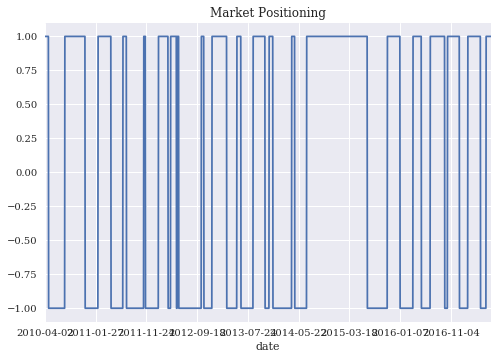

In [53]:
data['position'].plot(ylim=[-1.1, 1.1], title='Market Positioning')

### 3. 计算策略年化收益并可视化

In [54]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))    
#Numpy向量化；循环做法（尽量避免）,连续return

In [55]:
data.head()

,open,price,high,low,volume,code,SMA_10,SMA_60,position,returns
date,,,,,,,,,,
2010-04-02,3400.139,3407.281,3412.20,3391.81,69015592.0,hs300,3323.0607,3313.824200,1,NaN
2010-04-06,3422.849,3405.442,3436.29,3386.89,65191710.0,hs300,3333.3610,3311.644550,1,-0.000540
2010-04-07,3403.088,3387.705,3404.58,3369.02,54011228.0,hs300,3344.5387,3308.705667,1,-0.005222
2010-04-08,3381.306,3346.409,3381.31,3336.16,62185322.0,hs300,3351.4709,3305.442333,1,-0.012265
2010-04-09,3348.773,3379.365,3379.40,3342.47,51263265.0,hs300,3366.4918,3303.893200,1,0.009800


In [ ]:
# data['returns_dis'] = data['price']/data['price'].shift(1)-1    #离散计算return方法1

In [ ]:
# data['return_dis2'] = data['price'].pct_change()                #离散计算return方法2

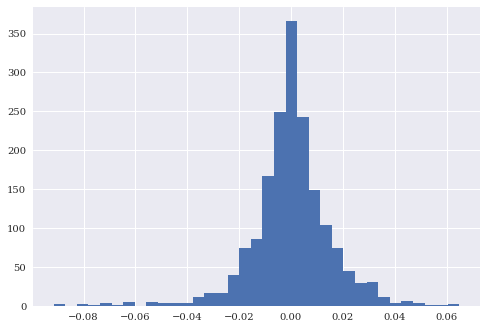

In [59]:
data['returns'].hist(bins=35)

In [60]:
data['strategy'] = data['position'].shift(1) * data['returns']     
#注意未来函数；一般会使得回测收益高估；

In [61]:
data[['returns', 'strategy']].sum()

returns     0.073405
strategy    0.727883
dtype: float64

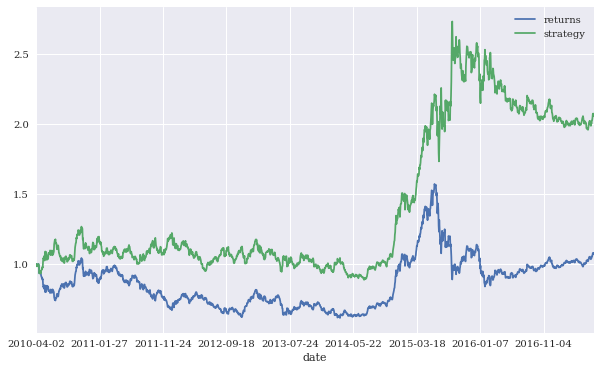

In [62]:
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))   #可视化；离散的计算方法参考Momoentum策略

### 4. 策略收益风险评估

In [63]:
data[['returns', 'strategy']].mean() * 252     #年化收益率；

returns     0.010516
strategy    0.104279
dtype: float64

In [64]:
data[['returns', 'strategy']].std() * 252 ** 0.5   #年化风险；

returns     0.245449
strategy    0.245362
dtype: float64

In [65]:
data['cumret'] = data['strategy'].cumsum().apply(np.exp)

In [66]:
data['cummax'] = data['cumret'].cummax()

In [67]:
data.tail()

,open,price,high,low,volume,code,SMA_10,SMA_60,position,returns,strategy,cumret,cummax
date,,,,,,,,,,,,,
2017-06-26,3627.02,3668.09,3671.94,3627.02,134637995.0,hs300,3573.455,3475.314500,1,0.012402,0.012402,2.071421,2.733857
2017-06-27,3665.58,3674.72,3676.53,3648.76,97558702.0,hs300,3582.700,3478.729667,1,0.001806,0.001806,2.075165,2.733857
2017-06-28,3664.16,3646.17,3672.19,3644.03,97920858.0,hs300,3593.787,3481.746000,1,-0.007800,-0.007800,2.059043,2.733857
2017-06-29,3649.25,3668.83,3669.13,3644.73,85589498.0,hs300,3607.791,3485.613833,1,0.006196,0.006196,2.071839,2.733857
2017-06-30,3654.73,3666.80,3669.76,3646.23,81510028.0,hs300,3622.595,3489.126333,1,-0.000553,-0.000553,2.070693,2.733857


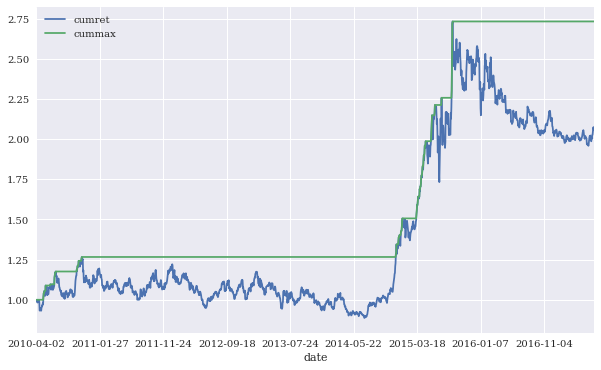

In [68]:
data[['cumret', 'cummax']].plot(figsize=(10, 6))

In [69]:
drawdown = (data['cummax'] - data['cumret'])

In [70]:
drawdown.max()           #计算原理：最大回撤；

0.77500599417732596

### 5. 策略优化的一种思路

In [7]:
hs300 = ts.get_k_data('hs300','2010-01-01', '2017-06-30')[['date','close']]
# hs300 = pd.DataFrame(hs300)
hs300.rename(columns={'close': 'price'}, inplace=True) 
hs300.set_index('date',inplace = True)
hs300.head()

,price
date,
2010-01-04,3536.221
2010-01-05,3564.038
2010-01-06,3542.209
2010-01-07,3472.313
2010-01-08,3480.403


In [49]:
hs300['SMA_10'] = hs300['price'].rolling(10).mean()       #必背

In [50]:
hs300['SMA_60'] = hs300['price'].rolling(60).mean()       #必背

In [51]:
hs300[['price', 'SMA_10', 'SMA_60']].tail()

,price,SMA_10,SMA_60
date,,,
2017-06-26,3668.09,3573.455,3475.314500
2017-06-27,3674.72,3582.700,3478.729667
2017-06-28,3646.17,3593.787,3481.746000
2017-06-29,3668.83,3607.791,3485.613833
2017-06-30,3666.80,3622.595,3489.126333


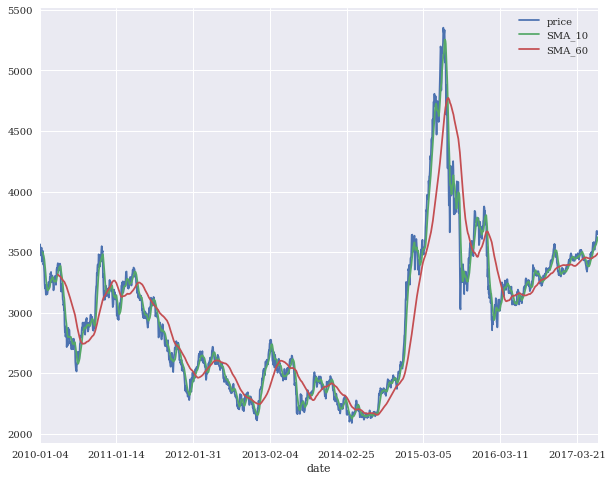

In [52]:
hs300[['price', 'SMA_10', 'SMA_60']].plot(grid=True, figsize = (10,8))

In [53]:
hs300['10-60'] = hs300['SMA_10'] - hs300['SMA_60']
hs300['10-60'].tail()

date
2017-06-26     98.140500
2017-06-27    103.970333
2017-06-28    112.041000
2017-06-29    122.177167
2017-06-30    133.468667
Name: 10-60, dtype: float64

In [54]:
SD = 20                     #阈值
hs300['regime'] = np.where(hs300['10-60'] > SD, 1,0)
hs300['regime'] = np.where(hs300['10-60'] < -SD, -1,hs300['regime'])    #核心重要；
hs300['regime'].value_counts()

 1    792
-1    751
 0    276
Name: regime, dtype: int64

In [55]:
hs300.tail(20)

,price,SMA_10,SMA_60,10-60,regime,Market,Strategy
date,,,,,,,
2017-06-05,3468.75,3457.542,3448.415500,9.126500,0,-0.005107,-0.005107
2017-06-06,3492.88,3466.445,3449.064167,17.380833,0,0.006932,0.006932
2017-06-07,3533.87,3478.708,3450.483167,28.224833,1,0.011667,0.011667
2017-06-08,3560.98,3492.387,3452.717167,39.669833,1,0.007642,0.007642
2017-06-09,3576.17,3507.587,3455.188500,52.398500,1,0.004257,0.004257
2017-06-12,3574.39,3516.460,3457.126667,59.333333,1,-0.000498,-0.000498
2017-06-13,3582.27,3526.644,3459.219667,67.424333,1,0.002202,0.002202
2017-06-14,3535.30,3530.886,3460.414000,70.472000,1,-0.013199,-0.013199
2017-06-15,3528.79,3533.991,3461.202000,72.789000,1,-0.001843,-0.001843


In [56]:
hs300['Market'] = np.log(hs300['price']/hs300['price'].shift(1))

In [57]:
hs300['Strategy'] = hs300['regime'].shift(1) * hs300['Market']

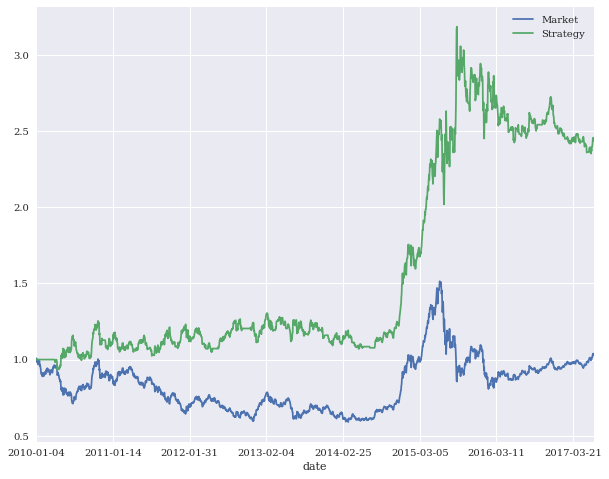

In [58]:
hs300[['Market','Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize = (10,8))

声明：本资料仅限内部研究和交流使用，切勿外传。